## Imports

In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk import FreqDist
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
import re
import contractions

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Read the Data
df = pd.read_csv('G2_RawData.csv')

## Data Understanding

About the dataset: This data is scraped from different baking websites.

In [3]:
# Display basic dataset info
print("Dataset Shape:", df.shape)
print("Dataset Head:")
df.head()

Dataset Shape: (2649, 3)
Dataset Head:


,title,difficulty_level,instructions
0,Dried Cherry Scones,Beginner,Preheat oven to 400˚F. Line a baking sheet wit...
1,Onion Marmalade BBQ Sauce,Easy,Place onions in a large frypan with the Chelse...
2,Hot Cross Donuts,Easy,"In a large bowl combine flour, sugar, yeast, c..."
3,Billie's Ginger Crunch,Easy,"Melt butter, Chelsea Golden Syrup and Chelsea ..."
4,Cookbook:Double Chocolate Cheesecake,intermediate,Crust Stir together crushed wafers and butter....


In [4]:
df.shape

(2649, 3)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2649 entries, 0 to 2648
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             2649 non-null   object
 1   difficulty_level  2597 non-null   object
 2   instructions      2645 non-null   object
dtypes: object(3)
memory usage: 62.2+ KB


In [6]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
title                0
difficulty_level    52
instructions         4
dtype: int64


In [7]:
# Remove rows where 'difficulty' or 'instructions' are empty
df = df.dropna(subset=['difficulty_level', 'instructions'])

In [8]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
title               0
difficulty_level    0
instructions        0
dtype: int64


In [9]:
# Remove 'title' column
df = df.drop(columns=['title'], errors='ignore')
df.columns

Index(['difficulty_level', 'instructions'], dtype='object')

### Frequency Distribution of the Most Frequent Words

In [10]:
# Tokenise words from the 'Text' column
all_words = [word.lower() for text in df['instructions'] for word in word_tokenize(text)]

# Generate frequency distribution for the words
freq_dist = FreqDist(all_words)
print(freq_dist)

# show top results
print(freq_dist.most_common(10))

<FreqDist with 11410 samples and 626538 outcomes>
[('the', 44145), ('.', 39417), ('and', 25708), (',', 24877), ('a', 19593), ('to', 15405), ('in', 11016), ('of', 9396), ('until', 8842), ('with', 8214)]


### Texts Fewer than 10 words

In [11]:
# Check if text has fewer than 15 words
def has_fewer_than_15_words(text):
    # Ensure text is a string and handle any missing values
    text = str(text)  # Convert text to string if it's not already
    return len(word_tokenize(text)) < 15

# Filter texts with fewer than 15 words
filtered_texts = df[df['instructions'].apply(has_fewer_than_15_words)]

# Display the filtered texts
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_colwidth', None)
filtered_texts[['instructions']]


,instructions
7,Mix all ingredients in a small bowl until well combined.


### Frequency Distribution of the Top 50 Words

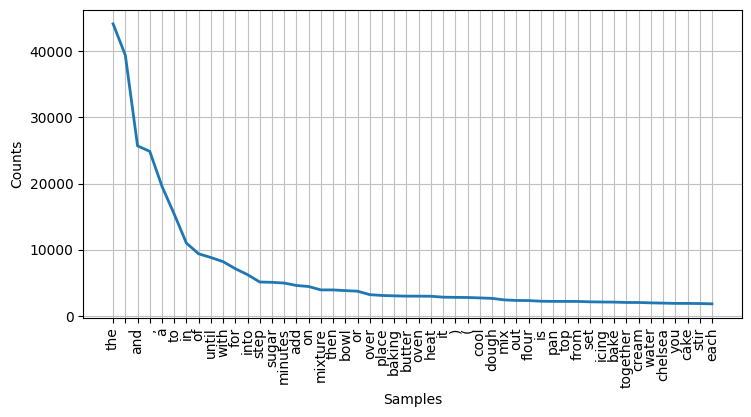

In [12]:
# Plot the frequency distribution for the top 50 words
plt.figure(figsize=(8.5, 4))
freq_dist.plot(50, cumulative=False)

# Display the plot
plt.show()

### Generate Word Cloud from Frequencies 

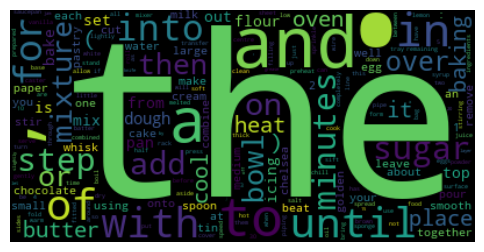

In [13]:
# create word cloud
wcloud = WordCloud().generate_from_frequencies(freq_dist)

# Plot the word cloud
plt.figure(figsize=(6, 4))
plt.imshow(wcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Generate Word Cloud from Frequencies (without stop words)

In [14]:
# Convert text to lowercase
df['instructions'] = df['instructions'].str.lower()
pd.set_option('display.max_colwidth', None)

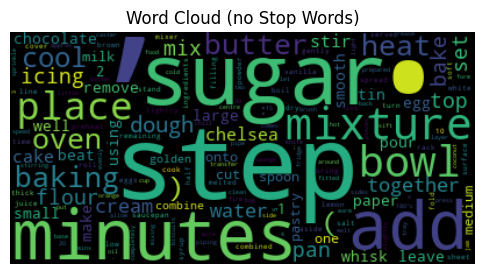

In [15]:
# GENERATE A WORD CLOUD WITHOUT THE STOPWORDS 
stop = set(stopwords.words('english'))

# Filter out stop words
filtered_words = [word for word in all_words if word not in stop]

# Generate frequency distribution for filtered words
filtered_freq_dist = FreqDist(filtered_words)

# Build word cloud without stop words
wcloud_filtered = WordCloud().generate_from_frequencies(filtered_freq_dist)

# Plot the word cloud without stop words
plt.figure(figsize=(6, 4))
plt.imshow(wcloud_filtered, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (no Stop Words)')
plt.show()

### Summary Statistics for Text Lengths

In [16]:
# Summary Stats for text length
df['Text_Length'] = df['instructions'].apply(len) 
print(df['Text_Length'].describe())

count    2593.000000
mean     1187.046278
std      1086.830289
min        56.000000
25%       498.000000
50%       795.000000
75%      1485.000000
max      8315.000000
Name: Text_Length, dtype: float64


### Visual Distributon of Text Lengths

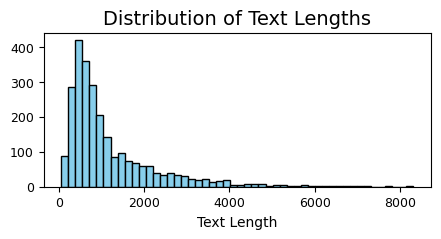

In [17]:
# dist of text lengths
plt.figure(figsize=(5, 2))
plt.hist(df['Text_Length'], bins=50, color='skyblue', edgecolor='black')  
plt.title('Distribution of Text Lengths', fontsize=14)  
plt.xlabel('Text Length', fontsize=10)  
plt.xticks(fontsize=9)  
plt.yticks(fontsize=9)  
plt.show()

### Visual Distributon of Word Counts

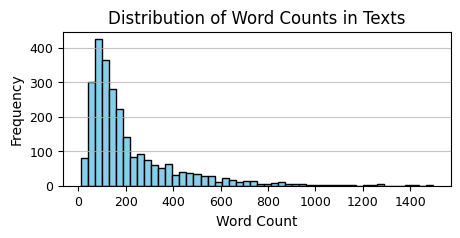

In [18]:
# Calculate the word count for each text
df['Word_Count'] = df['instructions'].str.split().map(lambda x: len(x))

# histogram
plt.figure(figsize=(5, 2))
plt.hist(df['Word_Count'], bins=50, color='skyblue', edgecolor='black')

# titles and labels
plt.title('Distribution of Word Counts in Texts', fontsize=12)
plt.xlabel('Word Count', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

# ticks and add gridlines
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.grid(axis='y', alpha=0.75)
plt.show()

### Bigrams and Trigrams Visualisations

In [19]:
# generate n-grams
def generate_ngrams(tokens, n):
    return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

In [20]:
# Generate bi-grams and tri-grams for each tokenized text
# Tokenize the 'Text' column
df['tokens'] = df['instructions'].apply(lambda x: word_tokenize(x.lower()))
df['bigrams'] = df['tokens'].apply(lambda x: generate_ngrams(x, 2))
df['trigrams'] = df['tokens'].apply(lambda x: generate_ngrams(x, 3))

In [21]:
# Count the freq of each bigram and trigram
bigram_counts = Counter(chain.from_iterable(df['bigrams']))
trigram_counts = Counter(chain.from_iterable(df['trigrams']))

In [22]:
# Get the top 10 most common bi-grams and tri-grams
top_bigrams = bigram_counts.most_common(10)
top_trigrams = trigram_counts.most_common(10)

In [23]:
# Convert bi-grams and tri-grams to strings for plotting
top_bigrams_strings = [' '.join(gram) for gram, count in top_bigrams]
top_bigrams_counts = [count for gram, count in top_bigrams]

In [24]:
top_trigrams_strings = [' '.join(gram) for gram, count in top_trigrams]
top_trigrams_counts = [count for gram, count in top_trigrams]

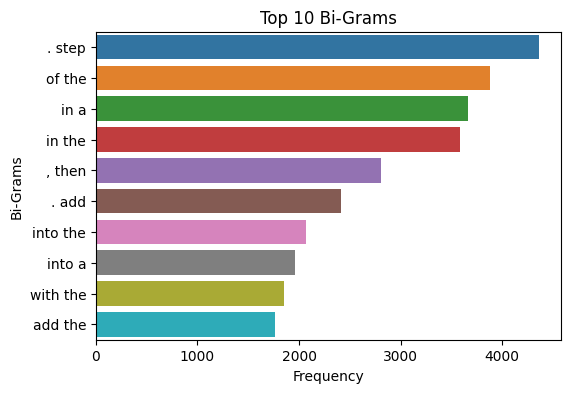

In [25]:
import seaborn as sns
# horizontal bar chart for bi-grams
plt.figure(figsize=(6, 4))
sns.barplot(x=top_bigrams_counts, y=top_bigrams_strings, hue=top_bigrams_strings, dodge=False, legend=False)
plt.title('Top 10 Bi-Grams')
plt.xlabel('Frequency')
plt.ylabel('Bi-Grams')
plt.legend([], [], frameon=False) # no legend
plt.show()

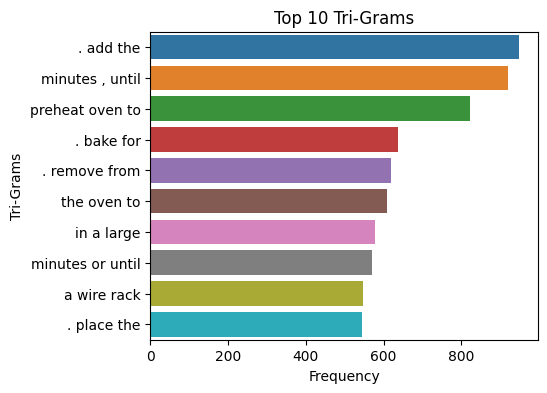

In [26]:
# horizontal bar chart for tri-grams
plt.figure(figsize=(5, 4))
sns.barplot(x=top_trigrams_counts, y=top_trigrams_strings, hue=top_trigrams_strings, dodge=False, legend=False)
plt.title('Top 10 Tri-Grams')
plt.xlabel('Frequency')
plt.ylabel('Tri-Grams')
plt.legend([], [], frameon=False) # no legend
plt.show()

#### Converting °F and °C to words

In [27]:
def convert_temp_to_words(text):
    # Handle temperatures with degree symbol (e.g., 190°c, 170°c)
    text = re.sub(r'(\d+)\s*°\s*c', r'\1degrees_celsius', text)  # Replace °c with degrees_celsius
    text = re.sub(r'(\d+)\s*°\s*f', r'\1degrees_fahrenheit', text)  # Replace °f with degrees_fahrenheit

    # Handle temperatures with "degrees celsius" and "degrees fahrenheit" (e.g., 190 degrees celsius)
    text = re.sub(r'(\d+)\s*degrees?\s*celsius', r'\1degrees_celsius', text)  # Replace degrees celsius with degrees_celsius
    text = re.sub(r'(\d+)\s*degrees?\s*fahrenheit', r'\1degrees_fahrenheit', text)  # Replace degrees fahrenheit with degrees_fahrenheit

    return text

# Step 8: Apply temperature symbol replacement to the 'instructions' column
df['instructions'] = df['instructions'].apply(convert_temp_to_words)

#### Making Pre and Heat one Word -> "Preheat

In [28]:
def fix_preheat_spacing(text):
    """Replace variations of 'pre heat' with 'preheat'."""
    text = re.sub(r'\bpre\s*heat\b', 'preheat', text, flags=re.IGNORECASE)
    return text

# Apply function to df['instructions']
df['instructions'] = df['instructions'].apply(fix_preheat_spacing)

#### Expanding Contractions

In [29]:
def expand_contractions(text):
    # Expand contractions using the contractions library
    return contractions.fix(text)

# Apply the function to the 'instructions' column
df['instructions'] = df['instructions'].apply(expand_contractions)

### RemovaL of \n

In [30]:
# Step 9: Remove newline characters and replace them with a space
df['instructions'] = df['instructions'].str.replace('\n', ' ', regex=False)

#### Removal of Steps 
Removed the word "Step" and thier numbers because it doesn't provide much meaning to the difficulty of the recipe

In [31]:
import re

def remove_step_indicators(text):
    """Remove step indicators like 'Step 1', 'Step one', etc."""
    # Remove numeric step indicators (e.g., "Step 1", "step 23")
    text = re.sub(r'step\s*\d+', '', text, flags=re.IGNORECASE)
    
    # Remove common word-based step indicators (up to 'step twenty')
    step_words = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
                  'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen', 'seventeen',
                  'eighteen', 'nineteen', 'twenty']

    for word in step_words:
        text = re.sub(rf'step\s*{word}', '', text, flags=re.IGNORECASE)

    # Remove extra spaces caused by the replacements
    return re.sub(r'\s+', ' ', text).strip()

# Apply function to df['instructions']
df['instructions'] = df['instructions'].apply(remove_step_indicators)

#### Make bigrams - make 2 words into 1 token

In [32]:
def fix_common_mistakes(text):
    """Fixes spacing and common word mistakes."""
    replacements = {
        r'\bpre\s*heat\b': 'preheat',
        r'\bset\s*aside\b': 'set_aside',
        r'\bmins\b': 'minutes',
        r'\bice\s*cream\b': 'ice_cream',
        r'\bcreme\b': 'cream',
        r'\bsift\s*together\b': 'sift_together',
        r'\bstir\s*in\b': 'stir_in',
        r'\bmix\s*in\b': 'mix_in',
        r'\bwhip\s*up\b': 'whip_up',
        r'\bsprinkle\s*over\b': 'sprinkle_over',
        r'\bfold\s*in\b': 'fold_in'
    }
    for pattern, replacement in replacements.items():
        text = re.sub(pattern, replacement, text)
    return text

df['instructions'] = df['instructions'].apply(fix_common_mistakes)

#### Standarise the word temperature

In [33]:
# Function 3: Remove temperature variations like "350of (180oc)", "150ºc", "300ºf", "fan", etc.
def clean_temperatures(text):
    """Removes various temperature formats."""
    text = re.sub(r'\d+º?[cf]', '', text)  # Removes "150ºc", "300ºf", etc.
    text = re.sub(r'\d+of\s*\(\d+oc\)', '', text)  # Removes "350of (180oc)"
    text = re.sub(r'\b(fan|gas\s*mark\s*\d+)\b', '', text)  # Removes "fan", "gas mark 6"
    return text

df['instructions'] = df['instructions'].apply(clean_temperatures)

#### change abbreviations to the full word

In [34]:
# Function 6: Replace abbreviations (e.g., "tsp" → "teaspoon")
def replace_abbreviations(text):
    """Replaces common abbreviations."""
    abbreviations = {
        r'\btsp\b': 'teaspoon',
        r'\btbsp\b': 'tablespoon',
        r'\bcup\b': 'cup',
        r'\boz\b': 'ounce',
        r'\blb\b': 'pound',
        r'\bqt\b': 'quart',
        r'\bgal\b': 'gallon',
        r'\bml\b': 'milliliter',
        r'\bl\b': 'liter',
        r'\bg\b': 'gram',
        r'\bkg\b': 'kilogram',
        r'\bdoz\b': 'dozen',
        r'\bcl\b': 'centiliter',
        r'\bfl\b': 'fluid',
        r'\bpkg\b': 'package',
        r'\bbp\b': 'baking_powder',
        r'\bb_s\b': 'baking_soda'
    }
    for pattern, replacement in abbreviations.items():
        text = re.sub(pattern, replacement, text)
    return text

df['instructions'] = df['instructions'].apply(replace_abbreviations)

#### Check for HTML Tags

In [35]:
# Step 10: Function to check if there are HTML tags in the text
def contains_html(text):
    return bool(re.search(r'<.*?>', text))

# Step 11: Apply the function to the 'instructions' column to check each row
df['contains_html'] = df['instructions'].apply(contains_html)

In [36]:
# Step 12: Display rows that contain HTML tags
html_rows = df[df['contains_html'] == True]
print("Rows containing HTML tags:")
print(html_rows[['instructions']])

Rows containing HTML tags:
Empty DataFrame
Columns: [instructions]
Index: []


### Handling Hypens and keeping ngrams of time (Eg 2 minutes)
want to keep word like '1 minute' and '2 minute' as a token as the duration of the recipe could potentiall affect the difficulty of the recipe

In [37]:
# Step 13: Tokenizer function for hyphen handling and time units
def tokenize_with_hyphen_and_units(text):
    # Replace hyphens in words with underscores (e.g., "easy-to-follow" becomes "easy_to_follow")
    text = text.replace('-', '_')
    
    # Match numbers with time units (e.g., "5 minutes", "10 hours") and replace space between number and unit with an underscore
    text = re.sub(r'(\d+)\s*(seconds|minutes|hours)', r'\1_\2', text)
    
    # Tokenize the text into words, accounting for hyphen replacements
    return re.findall(r'\b\w+(?:_\w+)*\b', text)

# Step 14: Apply the custom tokenizer to the 'instructions' column
df['tokens'] = df['instructions'].apply(tokenize_with_hyphen_and_units)

#### Removed Punctuation 
removed punctuation after handling token with hypens so the hypens don't get removed

In [38]:
# Step 15: Remove punctuation from tokens (keeping underscores)
df['tokens'] = df['tokens'].apply(lambda words: [word.translate(str.maketrans('', '', string.punctuation.replace('_', ''))) for word in words])

#### remove stop words

In [39]:
from nltk.corpus import stopwords

# Load English stop words
stop_words = set(stopwords.words('english'))

def remove_stopwords_from_tokens(tokens):
    """Remove stop words from a list of tokens."""
    return [word for word in tokens if word.lower() not in stop_words]

# Apply the function to the 'tokens' column
df['tokens'] = df['tokens'].apply(remove_stopwords_from_tokens)

#### Remove single standalone numbers

In [40]:
def remove_numeric_tokens(tokens):
    """Remove tokens that are purely numeric."""
    return [word for word in tokens if not word.isdigit()]

# Apply the function to df['tokens']
df['tokens'] = df['tokens'].apply(remove_numeric_tokens)

#### Remove single standalone letters

In [41]:
def remove_single_letter_tokens(tokens):
    """Remove tokens that are single letters."""
    return [word for word in tokens if len(word) > 1]

# Apply the function to df['tokens']
df['tokens'] = df['tokens'].apply(remove_single_letter_tokens)

#### Removes Weird patterns of numbers

In [42]:
# Function 1: Remove unwanted patterns like "9x5_", "13_", "2x"
def remove_unwanted_patterns(tokens):
    """Removes tokens with patterns like '9x5_', '13_', '2x'."""
    return [token for token in tokens if not re.match(r'\d+x\d+_|^\d+_$|^\d+x$', token)]

df['tokens'] = df['tokens'].apply(remove_unwanted_patterns)

#### Removes Domain stop words

In [43]:
common_stopwords = set(stopwords.words('english')) | {
     "either", "onto", "also", "use", "using", "let", "allow", "need", 
    "make", "made", "place", "take", "remove", "set",
    "well", "ensure", "keep", "press", 
    "put", "top", "work", "help", "slightly", "form", "continue"
}

def remove_stopwords(tokens):
    """Removes common stopwords."""
    return [word for word in tokens if word not in common_stopwords]

df['tokens'] = df['tokens'].apply(remove_stopwords)

#### Removes single numbers alone as they dont have much significance

In [44]:
# Function 5: Remove single numbers, fractions, and standalone letters
def remove_unwanted_tokens(tokens):
    """Removes single numbers, fractions (like 1½), single letters, and two-letter words."""
    return [token for token in tokens if not re.match(r'^\d+$', token) and not re.match(r'^\d+½$', token) and len(token) > 2]

df['tokens'] = df['tokens'].apply(remove_unwanted_tokens)

In [45]:
df[['instructions','tokens']].iloc[1721:1723]

,instructions,tokens
1759,"place dark chocolate and chelsea golden syrup in heatproof bowl over a saucepan of simmering water. stir until melted and smooth. allow to cool slightly. beat egg whites in a separate bowl with an electric mixer until soft peaks form. add chelsea dark cane sugar and continue beating until stiff peaks form. set_aside. stir egg yolk into melted chocolate mixture. beat cream until soft peaks form. carefully fold through chocolate and egg yolk mixture. fold through egg whites. spoon into small latte glasses. refrigerate for 1 hour or until set. sprinkle drinking chocolate for gravel, flowers and press tombstones into mousses.","[dark, chocolate, chelsea, golden, syrup, heatproof, bowl, saucepan, simmering, water, stir, melted, smooth, cool, beat, egg, whites, separate, bowl, electric, mixer, soft, peaks, add, chelsea, dark, cane, sugar, beating, stiff, peaks, set_aside, stir, egg, yolk, melted, chocolate, mixture, beat, cream, soft, peaks, carefully, fold, chocolate, egg, yolk, mixture, fold, egg, whites, spoon, small, latte, glasses, refrigerate, hour, sprinkle, drinking, chocolate, gravel, flowers, tombstones, mousses]"
1760,"place a saucer in the freezer. cut a shallow cross in the base of each peach. place peaches in a large heatproof bowl and cover with boiling water. set_aside for 5 minutes. drain. use your fingers to carefully peel. retain peel for later. cut peach flesh into m pieces. peel, quarter and core the apple. cut the apple flesh into m pieces. wrap the apple flesh, skin, core and peach skins in a piece of muslin and tie with un-waxed white kitchen string to enclose. place the peach flesh, muslin pouch, water, lime juice and 2 reserved lime halves in a large saucepan over medium heat. bring to the boil. simmer over a medium heat, stirring, for 25 minutes or until the peach is soft. discard the lime halves and muslin pouch. reduce heat; add chelsea jam setting sugar, stirring over a medium heat for 1 minute or until sugar dissolves. bring to the boil and boil rapidly for 3 - 4 minutes (removing any scum with a large metal spoon). you can start testing at 3 minutes. setting time will vary depending on saucepan size and heat of hot plate. test a small amount of jam on the cold saucer (the surface should wrinkle when a spoon is pushed through it). ladle hot jam into sterilised jars and screw on lid to seal. turn upside down for 5 minutes to draw a vacuum. turn upright and set_aside until cooled. label, date and store in a cool, dark place. refrigerate after opening.makes: 2 x 300ml jars.","[saucer, freezer, cut, shallow, cross, base, peach, peaches, large, heatproof, bowl, cover, boiling, water, set_aside, 5_minutes, drain, fingers, carefully, peel, retain, peel, later, cut, peach, flesh, pieces, peel, quarter, core, apple, cut, apple, flesh, pieces, wrap, apple, flesh, skin, core, peach, skins, piece, muslin, tie, un_waxed, white, kitchen, string, enclose, peach, flesh, muslin, pouch, water, lime, juice, reserved, lime, halves, large, saucepan, medium, heat, bring, boil, simmer, medium, heat, stirring, 25_minutes, peach, soft, discard, lime, halves, muslin, pouch, reduce, heat, add, chelsea, jam, setting, sugar, stirring, medium, heat, minute, sugar, dissolves, bring, boil, boil, rapidly, 4_minutes, removing, scum, large, metal, ...]"


#### Cleaned Frequency Distribution

In [46]:
# Flatten the list of tokens from the 'tokens' column
all_tokens = [word for tokens in df['tokens'] for word in tokens]

# Generate frequency distribution for the tokens
freq_dist = FreqDist(all_tokens)

# Print the frequency distribution
print(freq_dist)

# Show top 10 most common tokens
print(freq_dist.most_common(10))


<FreqDist with 7654 samples and 294381 outcomes>
[('sugar', 5125), ('add', 4926), ('mixture', 3955), ('bowl', 3845), ('heat', 3228), ('baking', 3057), ('butter', 3028), ('oven', 3013), ('cool', 2771), ('dough', 2674)]


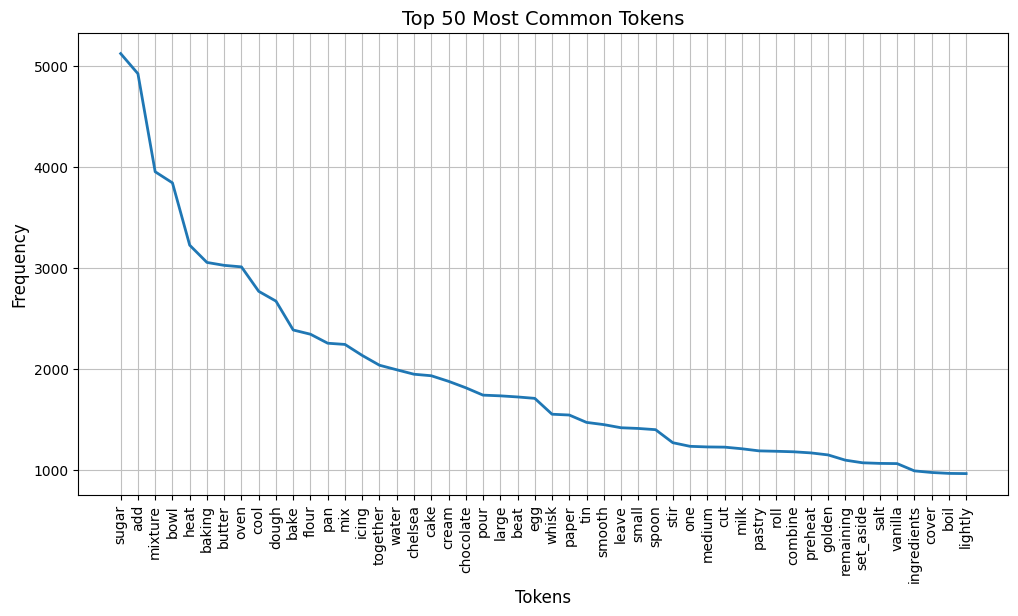

In [47]:
import matplotlib.pyplot as plt
from nltk import FreqDist

# Flatten the list of tokens from the 'tokens' column
all_tokens = [word for tokens in df['tokens'] for word in tokens]

# Generate frequency distribution for the tokens
freq_dist = FreqDist(all_tokens)

# Plot the frequency distribution for the top 50 words
plt.figure(figsize=(12, 6))  # Increase the size of the plot for better readability
freq_dist.plot(50, cumulative=False)

# Set title and labels for the plot
plt.title("Top 50 Most Common Tokens", fontsize=14)
plt.xlabel("Tokens", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Display the plot
plt.show()


#### Remove irrelavent words

In [63]:
# Define the list of words to remove
remove_words = ['chelsea', 'ingredients']

# Function to remove specified words from tokens
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in remove_words])

In [64]:
# Function to replace commas or underscores in tokenized data
def combine_special_tokens(tokens):
    # Replace commas and underscores with a single underscore
    return [re.sub(r'[^a-zA-Z0-9]+', '_', token) for token in tokens]

# Apply this function to the 'tokens' column
df['tokens'] = df['tokens'].apply(combine_special_tokens)

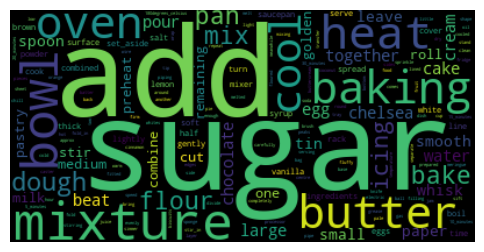

In [65]:
# create word cloud
wcloud = WordCloud().generate_from_frequencies(freq_dist)

# Plot the word cloud
plt.figure(figsize=(6, 4))
plt.imshow(wcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

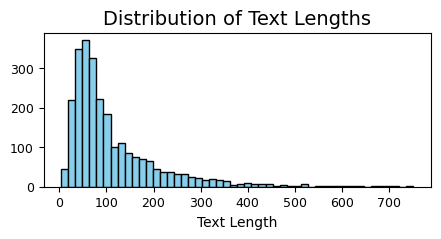

In [66]:
# Create a new column for text lengths based on the 'tokens' column
df['Text_Length'] = df['tokens'].apply(len)

# Plot the distribution of text lengths
plt.figure(figsize=(5, 2))
plt.hist(df['Text_Length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Lengths', fontsize=14)
plt.xlabel('Text Length', fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

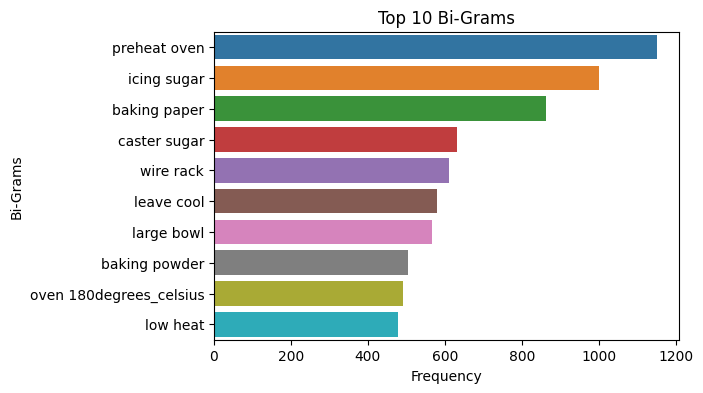

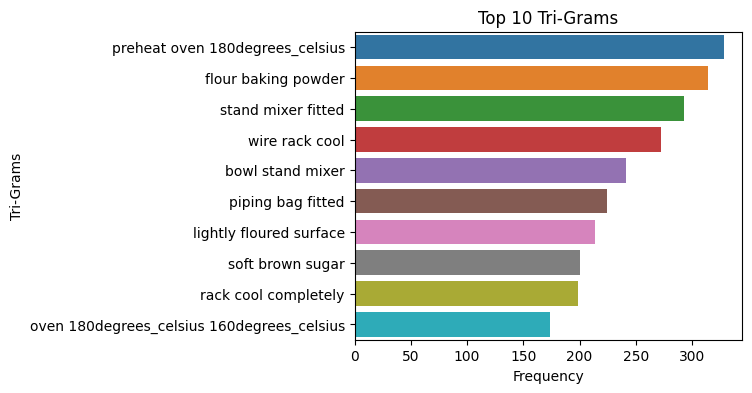

In [67]:
from collections import Counter
from itertools import chain
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

# Function to generate n-grams
def generate_ngrams(tokens, n):
    return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

# Assuming df['tokens'] is already a list of tokens (if not, you'd tokenize text here)
# Generate bi-grams and tri-grams for each tokenized entry
df['bigrams'] = df['tokens'].apply(lambda x: generate_ngrams(x, 2))
df['trigrams'] = df['tokens'].apply(lambda x: generate_ngrams(x, 3))

# Count the frequency of each bigram and trigram
bigram_counts = Counter(chain.from_iterable(df['bigrams']))
trigram_counts = Counter(chain.from_iterable(df['trigrams']))

# Get the top 10 most common bi-grams and tri-grams
top_bigrams = bigram_counts.most_common(10)
top_trigrams = trigram_counts.most_common(10)

# Convert bi-grams and tri-grams to strings for plotting
top_bigrams_strings = [' '.join(gram) for gram, count in top_bigrams]
top_bigrams_counts = [count for gram, count in top_bigrams]

top_trigrams_strings = [' '.join(gram) for gram, count in top_trigrams]
top_trigrams_counts = [count for gram, count in top_trigrams]

# Plot horizontal bar chart for bi-grams
plt.figure(figsize=(6, 4))
sns.barplot(x=top_bigrams_counts, y=top_bigrams_strings, hue=top_bigrams_strings, dodge=False, legend=False)
plt.title('Top 10 Bi-Grams')
plt.xlabel('Frequency')
plt.ylabel('Bi-Grams')
plt.legend([], [], frameon=False)  # No legend
plt.show()

# Plot horizontal bar chart for tri-grams
plt.figure(figsize=(5, 4))
sns.barplot(x=top_trigrams_counts, y=top_trigrams_strings, hue=top_trigrams_strings, dodge=False, legend=False)
plt.title('Top 10 Tri-Grams')
plt.xlabel('Frequency')
plt.ylabel('Tri-Grams')
plt.legend([], [], frameon=False)  # No legend
plt.show()


In [69]:
replacement_dict = {
    'brown sugar': 'brown_sugar',
    'piping bag': 'piping_bag',
    'wire rack': 'wire_rack',
    'baking powder': 'baking_powder',
    'low heat': 'low_heat'
}

# Function to replace phrases in the list of tokens
def replace_phrases(tokens, replacements):
    # Replace specific phrases in the tokens list with their corresponding replacement tokens
    for phrase, replacement in replacements.items():
        tokens = [replacement if word == phrase else word for word in tokens]
    return tokens

# Apply the function to replace phrases in 'tokens' column
df['tokens'] = df['tokens'].apply(lambda x: replace_phrases(x, replacement_dict))

In [70]:
import nltk
from nltk.stem import WordNetLemmatizer

# Download WordNet data (required by the lemmatizer)
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize each token
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Apply lemmatization to the tokens
df['tokens_lemmatized'] = df['tokens'].apply(lemmatize_tokens)

# Check the result
print(df['tokens'].head())

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Tia\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


0                [preheat, oven, line, baking, sheet, parchment, paper, set_aside, large, bowl, mix, flour, baking, powder, salt, sugar, together, apastry, cutter, cut, butter, flour, mixture, fine, crumbs, separate, bowl, whisk, together, milk, egg, almond, extract, add, wet, dried, cherries, flour, mixture, fork, mix, together, ragged, pour, mixture, lightly, floured, surface, bring, together, gently, apastry, scraper, careful, overmix, pat, shape, inch, thick, circle, large, sharp, knife, cut, circle, triangles, triangle, prepared, baking, sheet, approx, inches, apart, brush, tops, scones, whipping, cream, sprinkle, tops, sugar, baking, sheet, scones, freezer, 10_minutes, scones, freezer, bake, 15_20_minutes, bottoms, browned, scones, puffed, middle]
1                                                                                                                                                                                                                                           

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Join tokens back into strings
df['tokens_string'] = df['tokens'].apply(lambda x: ' '.join(x))

In [72]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))

In [73]:
# Fit and transform the 'tokens_string' column
X_tfidf = vectorizer.fit_transform(df['tokens_string'])

In [74]:
# Convert the result into a DataFrame to inspect the features
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

In [75]:
# Check the shape of the TF-IDF matrix and a preview
print(f"TF-IDF matrix shape: {X_tfidf.shape}")
print(X_tfidf_df.head())

TF-IDF matrix shape: (2593, 5000)
   100degrees_celsius  100g  100ml  100ml water  105degrees_celsius  \
0                 0.0   0.0    0.0          0.0                 0.0   
1                 0.0   0.0    0.0          0.0                 0.0   
2                 0.0   0.0    0.0          0.0                 0.0   
3                 0.0   0.0    0.0          0.0                 0.0   
4                 0.0   0.0    0.0          0.0                 0.0   

   10_12_minutes  10_15_minutes  10_minutes  10_minutes add  10_minutes beat  \
0            0.0            0.0    0.047852             0.0              0.0   
1            0.0            0.0    0.000000             0.0              0.0   
2            0.0            0.0    0.000000             0.0              0.0   
3            0.0            0.0    0.000000             0.0              0.0   
4            0.0            0.0    0.063509             0.0              0.0   

   ...  yolks caster  yolks cornflour  yolks sugar  yolks 